# Modeling Customer Bookings

## Import Libraries and packages

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

## Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [ ]:
bookings_df = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")
bookings_df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [ ]:
bookings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data type conversions

In [ ]:
bookings_df['flight_day'].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [ ]:
day_mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

bookings_df["flight_day_n"] = bookings_df["flight_day"].map(day_mapping)

In [ ]:
bookings_df["flight_day_n"].unique()

array([6, 3, 4, 1, 7, 2, 5])

In [ ]:
bookings_df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,flight_day_n
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,0.668780,0.296960,0.427140,7.277561,0.149560,3.814420
std,1.020165,90.451378,33.88767,5.41266,0.470657,0.456923,0.494668,1.496863,0.356643,1.992792
min,1.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,4.670000,0.000000,1.000000
25%,1.000000,21.000000,5.00000,5.00000,0.000000,0.000000,0.000000,5.620000,0.000000,2.000000
50%,1.000000,51.000000,17.00000,9.00000,1.000000,0.000000,0.000000,7.570000,0.000000,4.000000
75%,2.000000,115.000000,28.00000,13.00000,1.000000,1.000000,1.000000,8.830000,0.000000,5.000000
max,9.000000,867.000000,778.00000,23.00000,1.000000,1.000000,1.000000,9.500000,1.000000,7.000000


Let us visualize the boolean variables

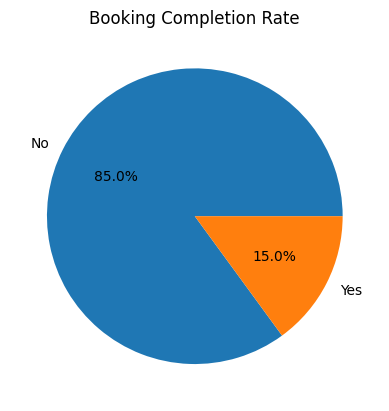

In [ ]:
plt.pie(bookings_df["booking_complete"].value_counts().sort_index(), labels=['No', 'Yes'], autopct='%1.1f%%')
plt.title("Booking Completion Rate")
plt.show()

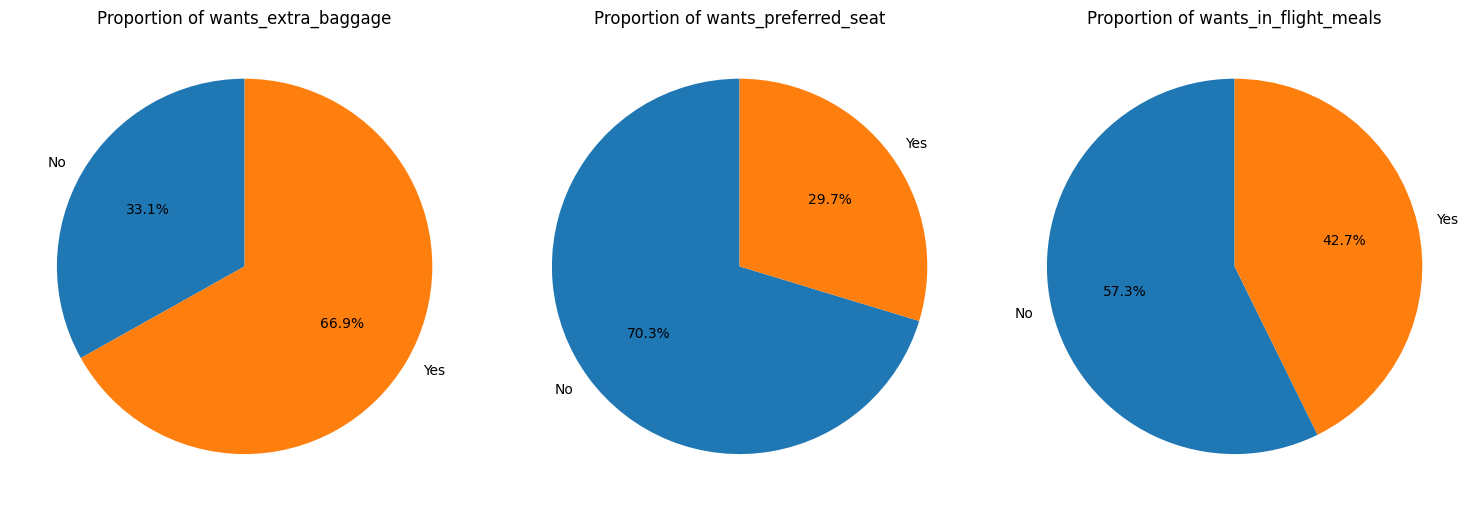

In [ ]:
bool_cols = ['wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, col in enumerate(bool_cols):
  axes[i].pie(bookings_df[col].value_counts().sort_index(), labels=['No', 'Yes'], autopct='%1.1f%%', startangle=90)
  axes[i].set_title(f"Proportion of {col}")

plt.tight_layout()
plt.show()

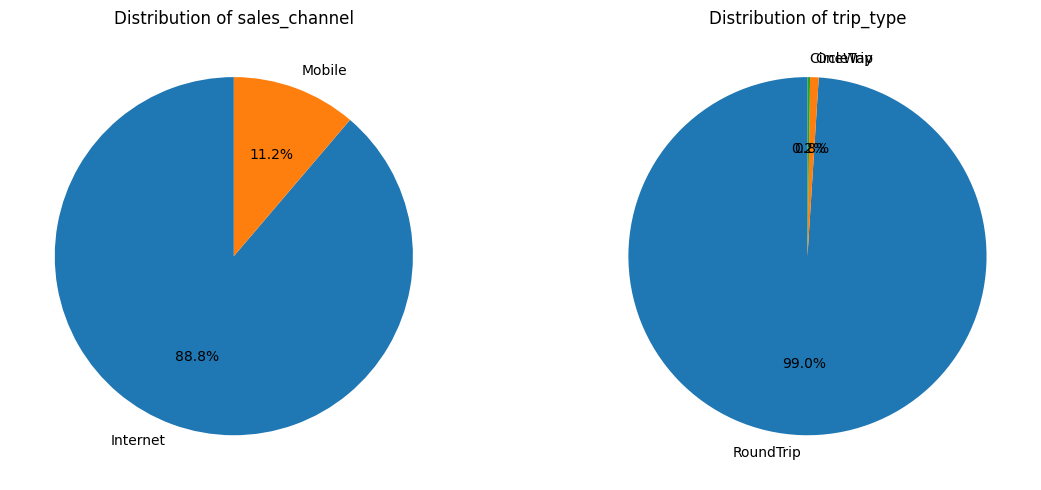

In [ ]:
categorical_cols = ['sales_channel', 'trip_type']

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, col in enumerate(categorical_cols):
  axes[i].pie(bookings_df[col].value_counts(), labels=bookings_df[col].value_counts().index, autopct='%1.1f%%', startangle=90)
  axes[i].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()


In [ ]:
flight_day_count = bookings_df['flight_day'].value_counts().sort_values(ascending=False)
flight_day_count

,count
flight_day,
Mon,8102
Wed,7674
Tue,7673
Thu,7424
Fri,6761
Sun,6554
Sat,5812


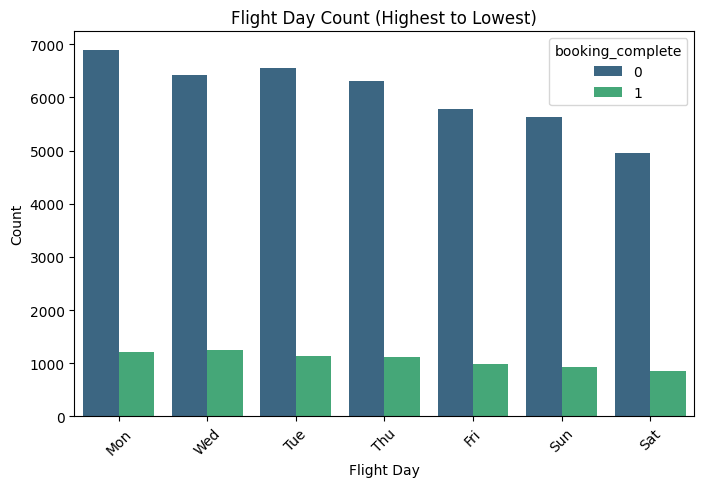

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x='flight_day', data=bookings_df, order=flight_day_count.index, hue ='booking_complete', palette='viridis')
plt.title('Flight Day Count (Highest to Lowest)')
plt.xlabel('Flight Day')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


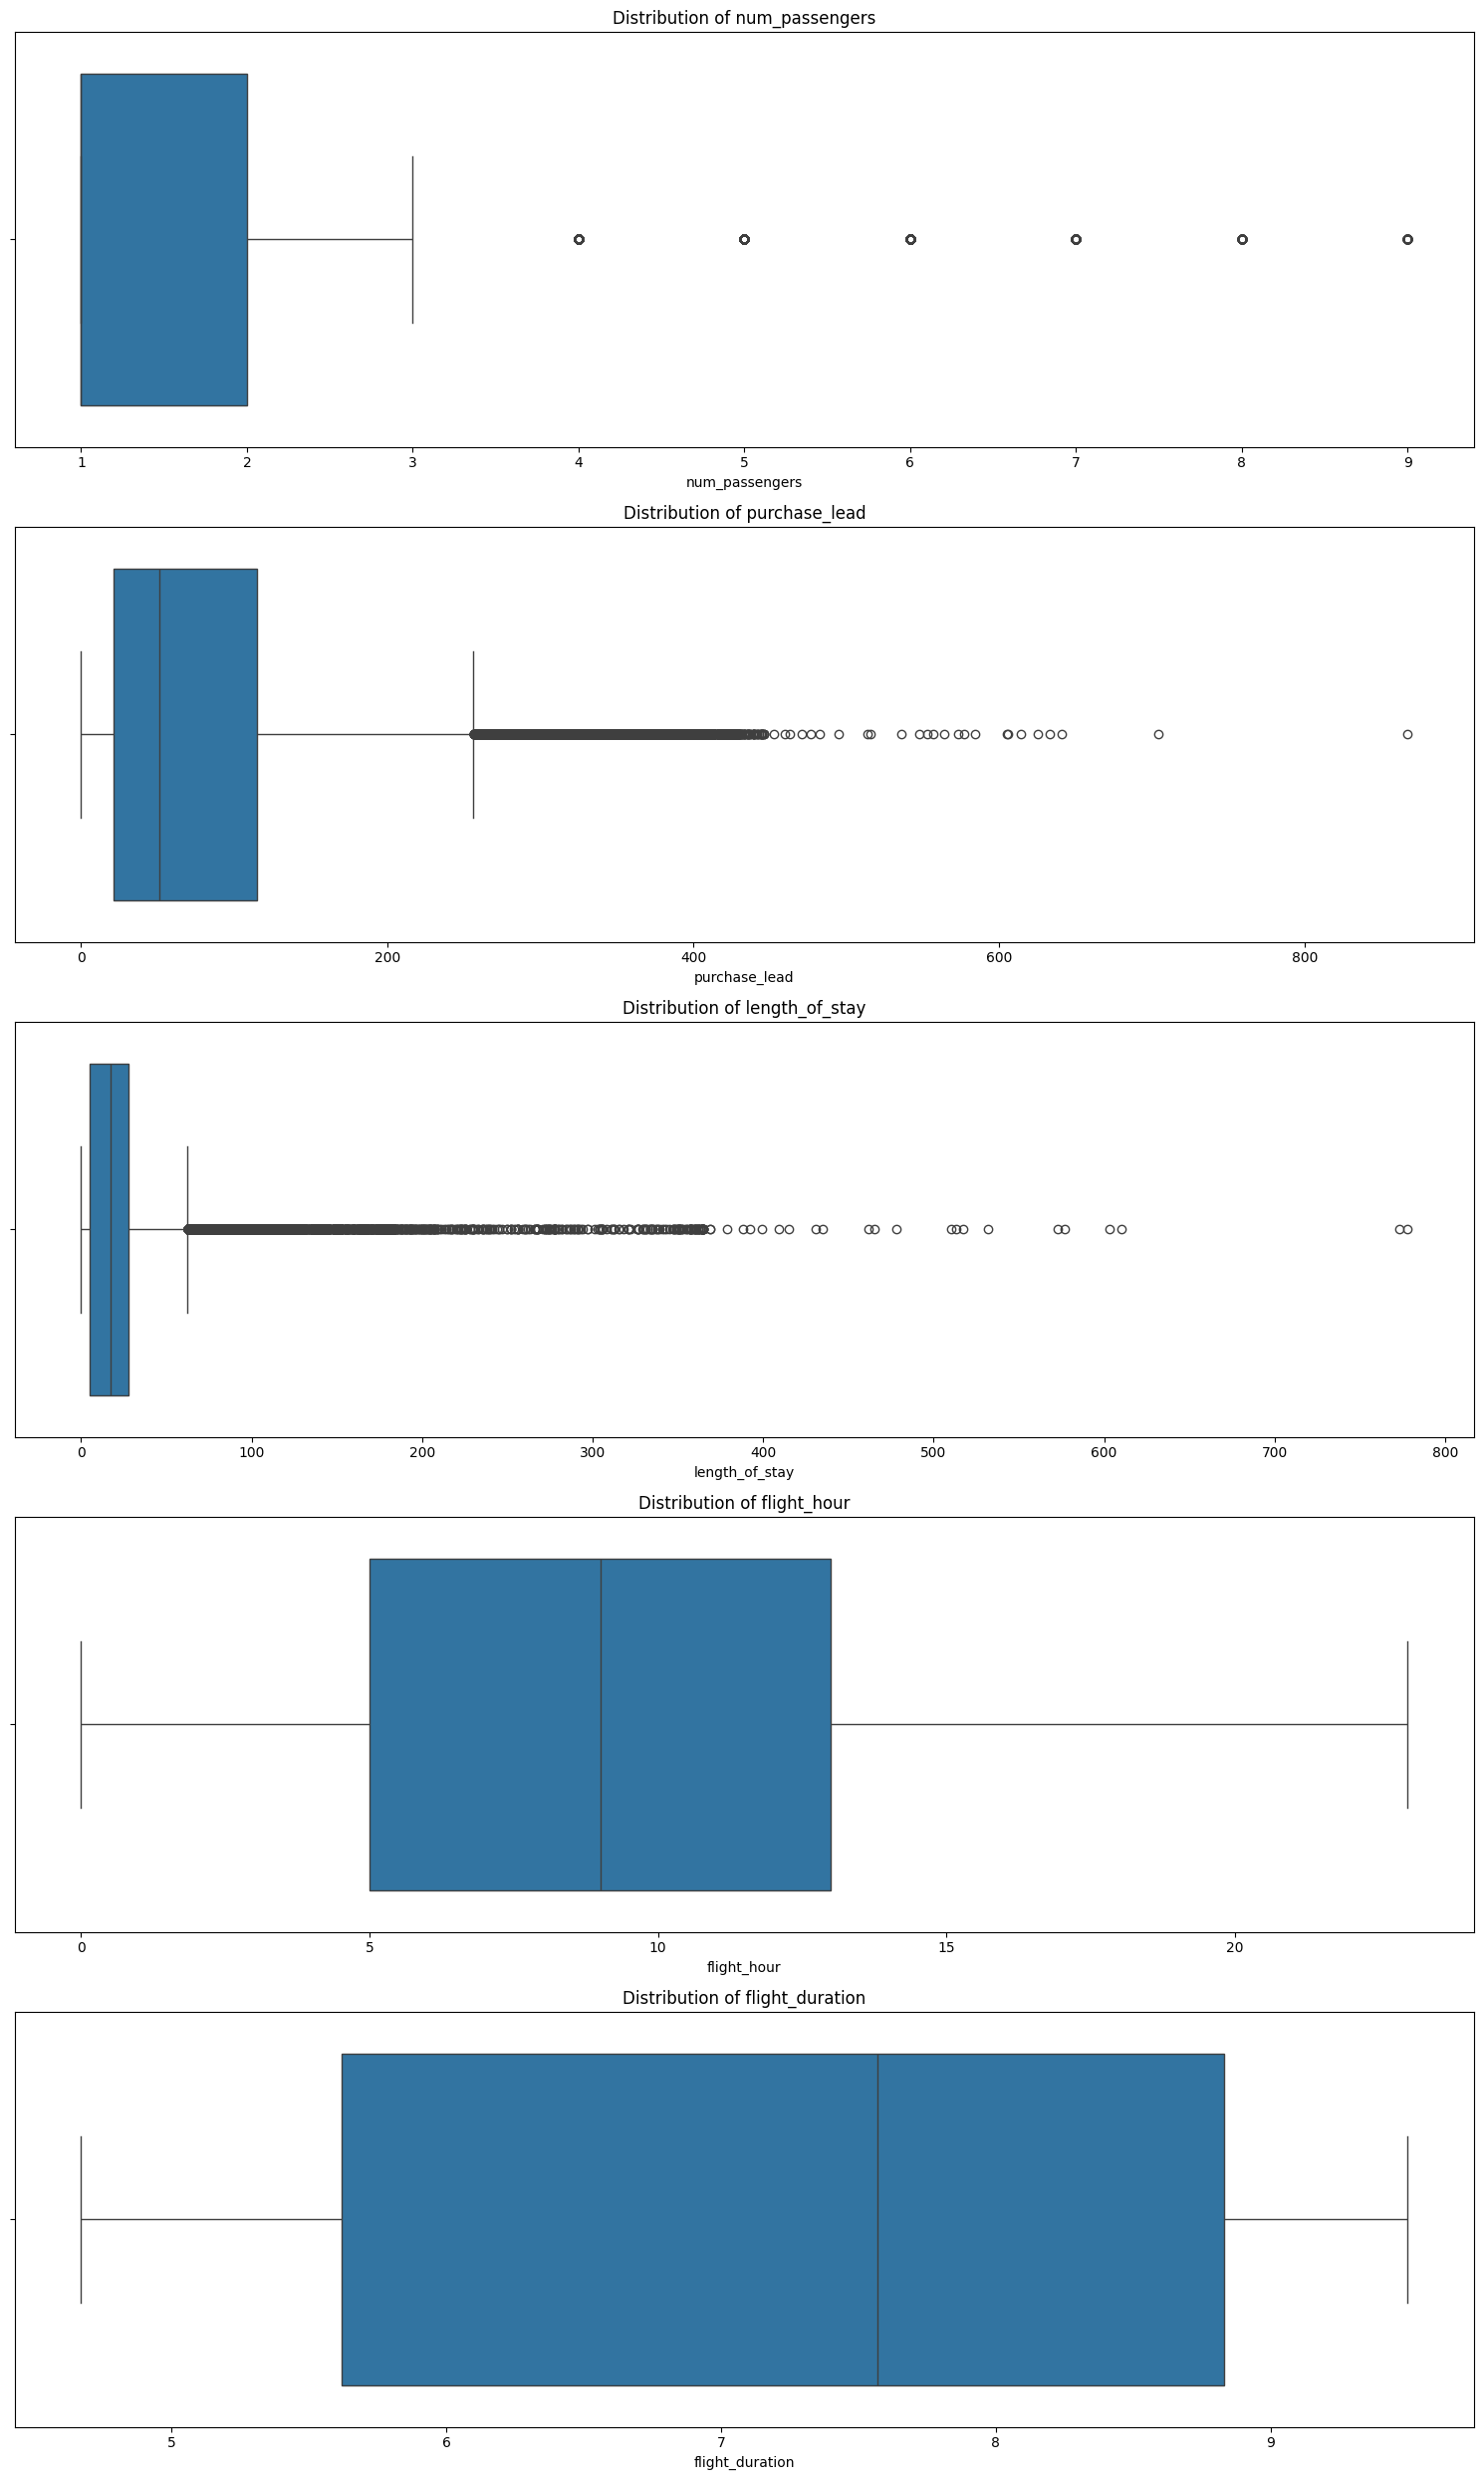

In [ ]:
numerical_cols = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration']

fig, axes = plt.subplots(len(numerical_cols), 1, figsize=(15, 25))

for i, col in enumerate(numerical_cols):
    sns.boxplot(x=bookings_df[col], ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()


In [ ]:
bookings_df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,flight_day_n
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0,6
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0,6
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0,3
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0,6
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0,3


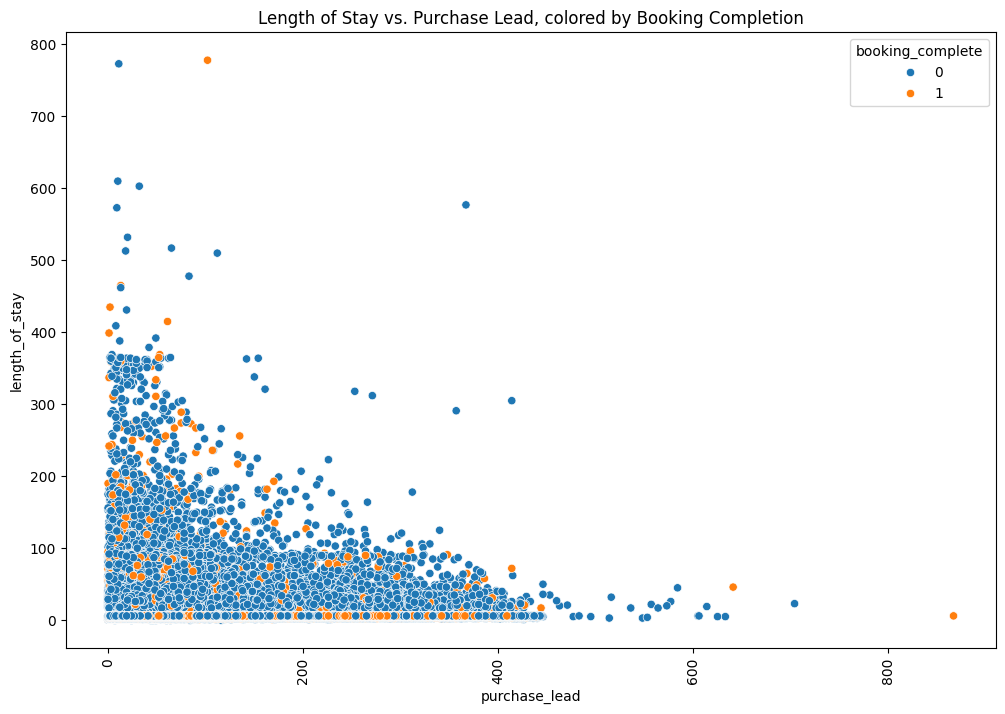

In [ ]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='purchase_lead', y='length_of_stay', hue='booking_complete', data=bookings_df)
plt.xticks(rotation=90)
plt.title('Length of Stay vs. Purchase Lead, colored by Booking Completion')
plt.show()


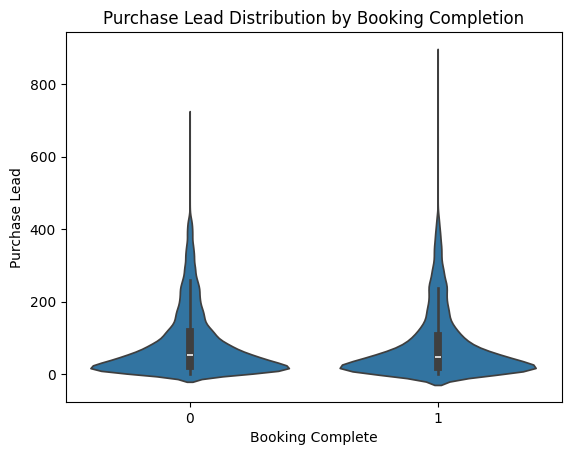

In [ ]:
sns.violinplot(x='booking_complete', y='purchase_lead', data=bookings_df)
plt.title('Purchase Lead Distribution by Booking Completion')
plt.xlabel('Booking Complete')
plt.ylabel('Purchase Lead')
plt.show()

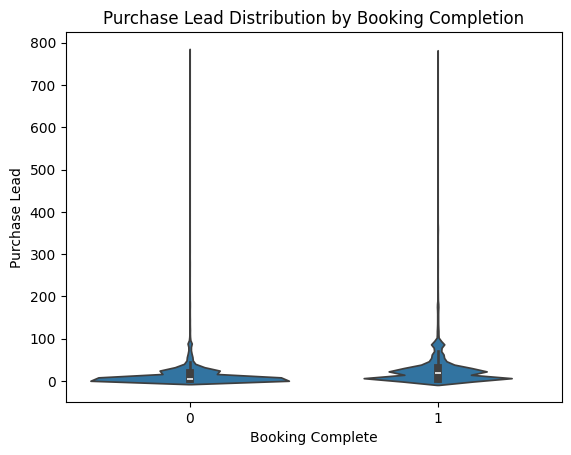

In [ ]:
sns.violinplot(x='wants_extra_baggage', y='length_of_stay', data=bookings_df)
plt.title('Purchase Lead Distribution by Booking Completion')
plt.xlabel('Booking Complete')
plt.ylabel('Purchase Lead')
plt.show()

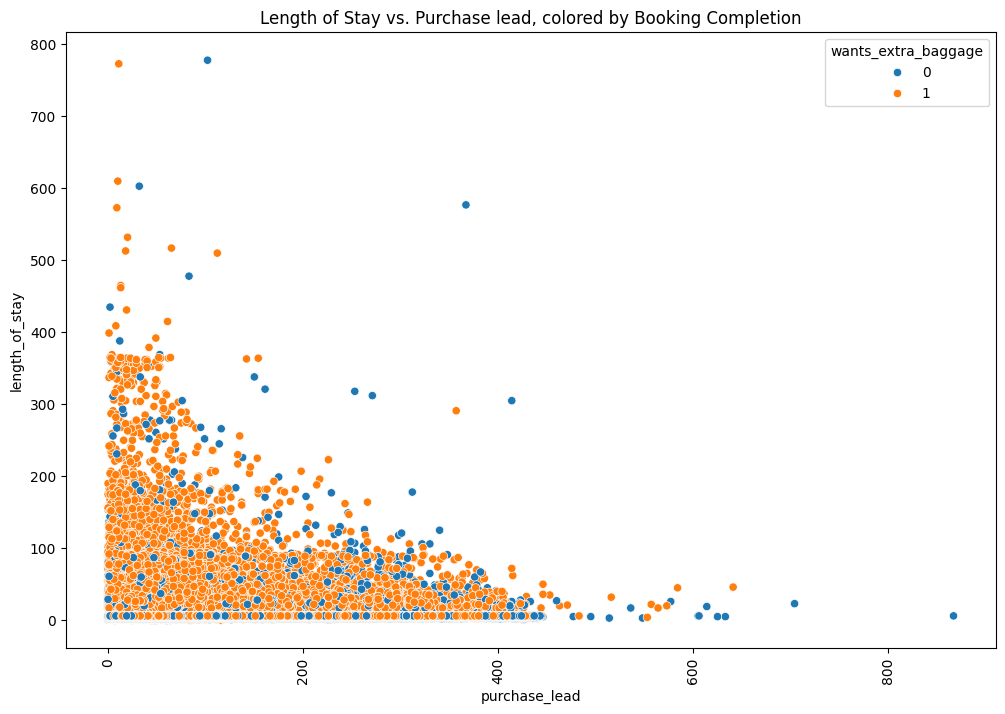

In [ ]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='purchase_lead', y='length_of_stay', hue='wants_extra_baggage', data=bookings_df)
plt.xticks(rotation=90)
plt.title('Length of Stay vs. Purchase lead, colored by Booking Completion')
plt.show()


In [ ]:
bookings_df[bookings_df['purchase_lead']>500]

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,flight_day_n
835,3,Internet,RoundTrip,641,46,6,Sun,AKLKUL,Malaysia,1,0,1,8.83,1,7
2058,2,Internet,RoundTrip,577,26,9,Mon,AKLKUL,New Zealand,0,0,0,8.83,0,1
2770,1,Internet,RoundTrip,557,22,19,Sat,BLRMEL,India,1,0,1,8.83,0,6
6148,1,Internet,RoundTrip,614,19,11,Wed,COKMEL,Australia,0,0,0,8.83,0,3
8770,2,Internet,RoundTrip,584,45,11,Sun,DELSYD,India,1,1,0,8.58,0,7
13478,4,Internet,RoundTrip,516,32,12,Tue,HYDSYD,Australia,1,0,0,8.58,0,2
20832,2,Internet,RoundTrip,573,20,23,Sat,MELTRZ,Australia,1,0,0,8.83,0,6
20919,2,Internet,RoundTrip,564,17,16,Sun,MELURT,Australia,1,0,1,8.83,0,7
22579,1,Internet,RoundTrip,536,17,4,Wed,PENPER,Australia,0,0,0,5.62,0,3
24119,1,Internet,RoundTrip,704,23,8,Tue,PNHSYD,Australia,0,0,0,8.58,0,2


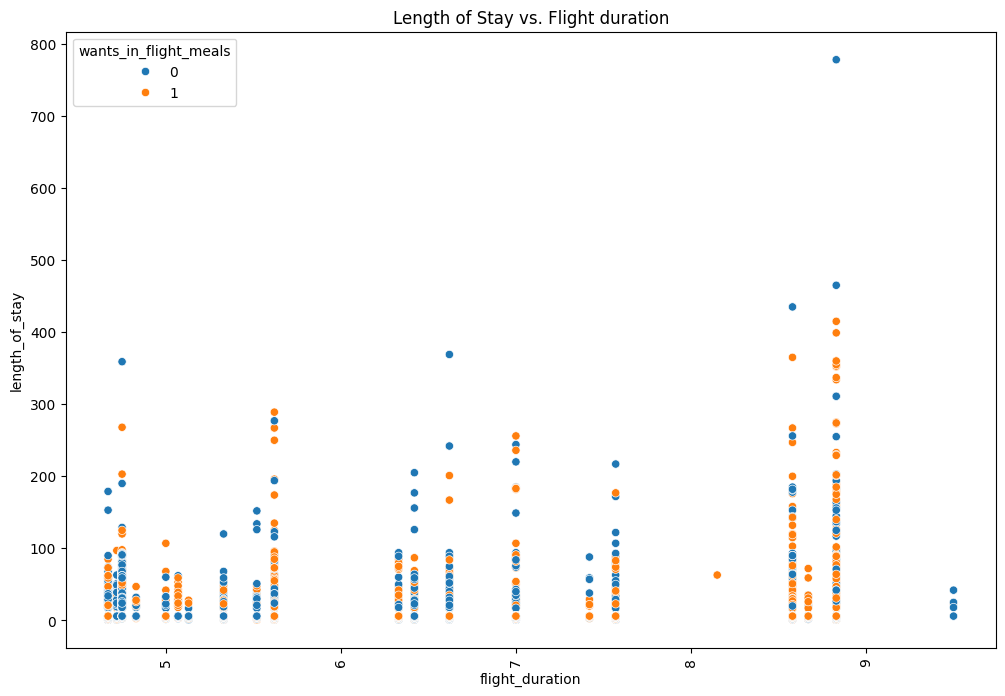

In [ ]:
plt.figure(figsize=(12, 8))
sns.scatterplot(y='length_of_stay', x='flight_duration', hue='wants_in_flight_meals', data=bookings_df[bookings_df['booking_complete']==1])
plt.xticks(rotation=90)
plt.title('Length of Stay vs. Flight duration')
plt.show()


In [ ]:
top_10_origins = bookings_df['booking_origin'].value_counts().head(10)

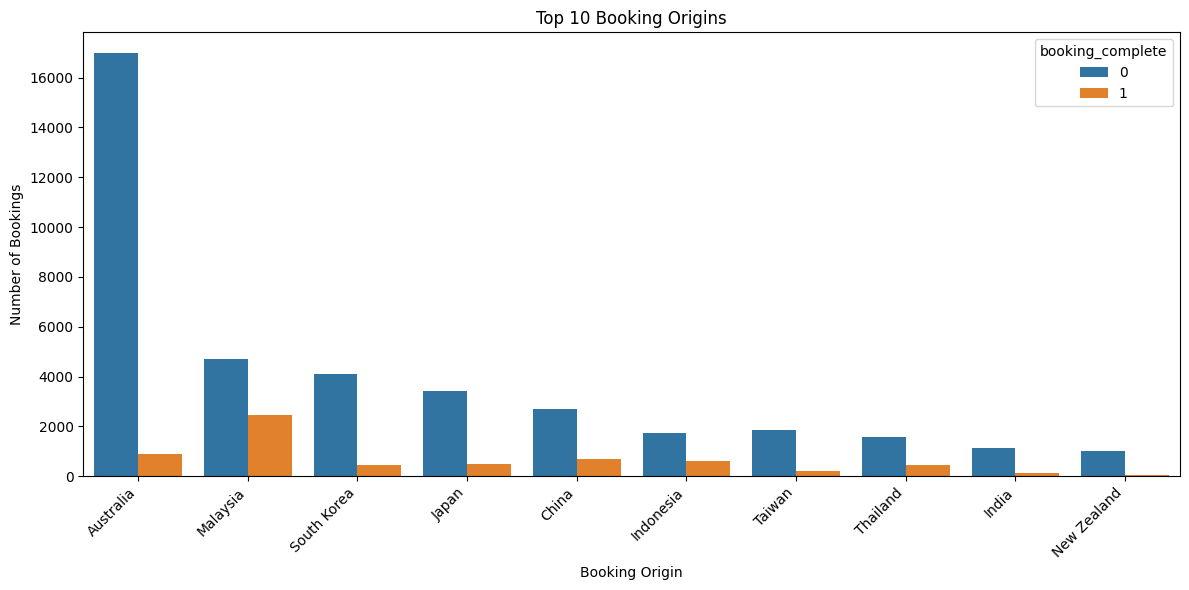

In [ ]:

plt.figure(figsize=(12, 6))
sns.countplot(data=bookings_df, x='booking_origin', order=top_10_origins.index, hue='booking_complete')
plt.title('Top 10 Booking Origins')
plt.xlabel('Booking Origin')
plt.ylabel('Number of Bookings')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


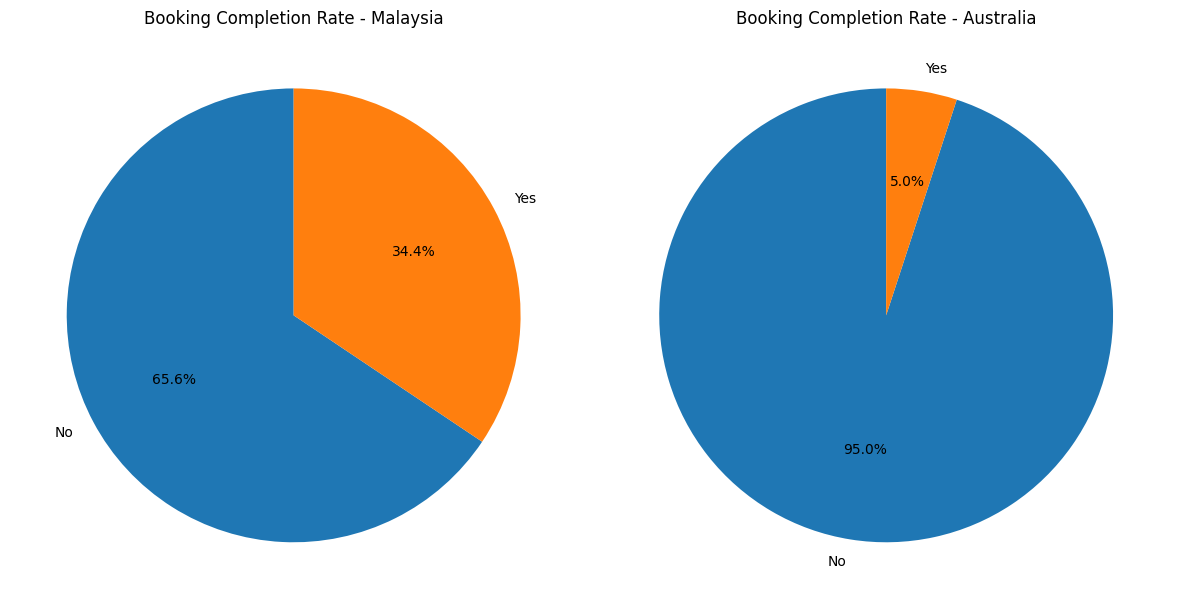

In [ ]:
def plot_booking_completion_by_country(df):
    # Filter data for Malaysia and Australia
    malaysia_data = df[df['booking_origin'] == 'Malaysia']
    australia_data = df[df['booking_origin'] == 'Australia']

    # Calculate booking completion rates
    malaysia_completion_rate = malaysia_data['booking_complete'].value_counts(normalize=True)
    australia_completion_rate = australia_data['booking_complete'].value_counts(normalize=True)

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Malaysia Pie Chart
    axes[0].pie(malaysia_completion_rate, labels=['No', 'Yes'], autopct='%1.1f%%', startangle=90)
    axes[0].set_title('Booking Completion Rate - Malaysia')

    # Australia Pie Chart
    axes[1].pie(australia_completion_rate, labels=['No', 'Yes'], autopct='%1.1f%%', startangle=90)
    axes[1].set_title('Booking Completion Rate - Australia')

    plt.tight_layout()
    plt.show()

plot_booking_completion_by_country(bookings_df)


## Feature Engineering

Firstly, let's encode variables

In [ ]:
ohe = OneHotEncoder(sparse_output=False, drop='first')
encoded_cols = pd.DataFrame(ohe.fit_transform(bookings_df[['sales_channel', 'trip_type']]))

In [ ]:
ohe.get_feature_names_out(['sales_channel', 'trip_type'])

array(['sales_channel_Mobile', 'trip_type_OneWay', 'trip_type_RoundTrip'],
      dtype=object)

In [ ]:
encoded_cols.columns = ohe.get_feature_names_out(['sales_channel', 'trip_type'])

In [ ]:
bookings_df=bookings_df.merge(encoded_cols, left_index=True, right_index=True)

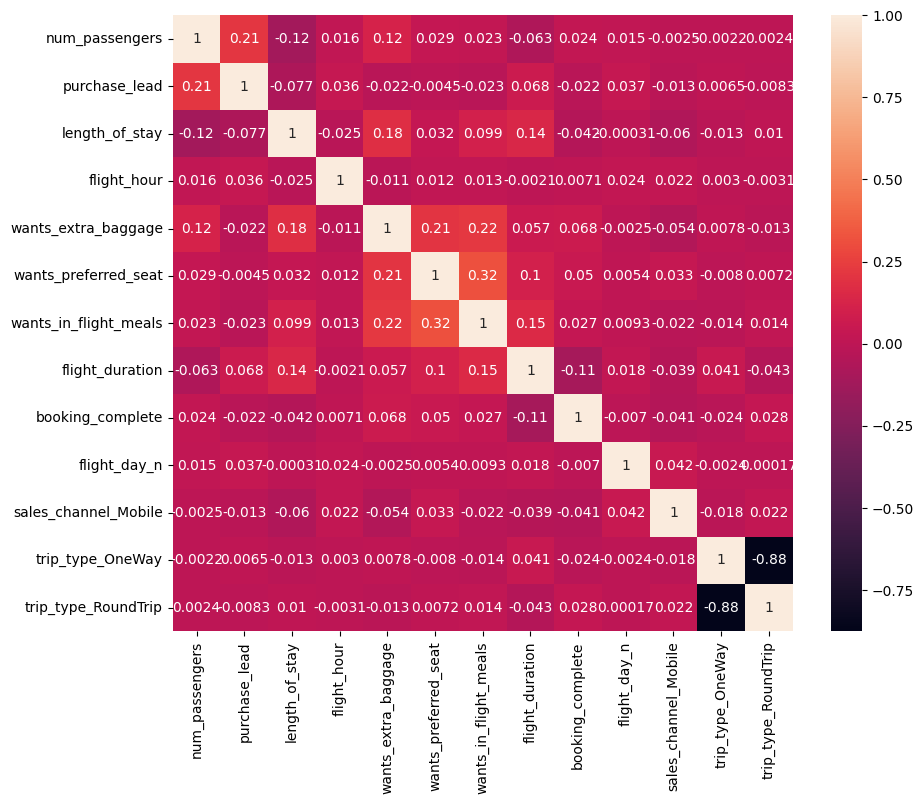

In [ ]:
# Let's visualize the correlation between variables
plt.figure(figsize=(10, 8))
sns.heatmap(bookings_df.corr(numeric_only=True), annot=True)
plt.show()

## Model Development

In [ ]:
bookings_df['booking_origin'].value_counts()

,count
booking_origin,
Australia,17872
Malaysia,7174
South Korea,4559
Japan,3885
China,3387
...,...
Ghana,1
Gibraltar,1
Guatemala,1


In [ ]:
bookings_df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,flight_day_n,sales_channel_Mobile,trip_type_OneWay,trip_type_RoundTrip
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0,6,0.0,0.0,1.0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0,6,0.0,0.0,1.0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0,3,0.0,0.0,1.0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0,6,0.0,0.0,1.0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0,3,0.0,0.0,1.0


In [ ]:
X = bookings_df.drop(['booking_complete', 'sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin'], axis=1)
y = bookings_df['booking_complete']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(40000, 12)
(10000, 12)
(40000,)
(10000,)


We have an imbalanced dataset here so let's attempt to balance this

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

In [ ]:
# from imblearn.over_sampling import RandomOverSampler
# ros = RandomOverSampler(random_state=42)
# X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

In [ ]:
model = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=1000)
model.fit(X_train_rus, y_train_rus)

RandomForestClassifier(class_weight='balanced', n_estimators=1000,
                       random_state=42)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.6196

In [ ]:
recall_score(y_test, y_pred)

0.6141891891891892

In [ ]:
precision_score(y_test, y_pred)

0.21945919845485273

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.62      0.74      8520
           1       0.22      0.61      0.32      1480

    accuracy                           0.62     10000
   macro avg       0.56      0.62      0.53     10000
weighted avg       0.80      0.62      0.67     10000



In [ ]:
confusion_matrix(y_test, y_pred)

array([[5287, 3233],
       [ 571,  909]])

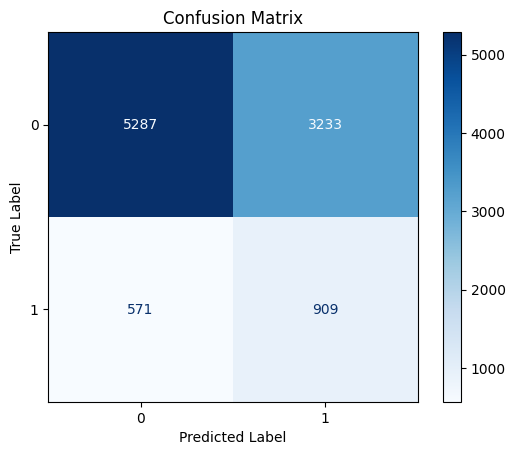

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
feature_importance = pd.DataFrame({
    'features': X_train.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=True)

In [ ]:
feature_importance

,features,importance
10,trip_type_OneWay,0.001355
11,trip_type_RoundTrip,0.002255
9,sales_channel_Mobile,0.013987
5,wants_preferred_seat,0.018401
4,wants_extra_baggage,0.020001
6,wants_in_flight_meals,0.024874
0,num_passengers,0.054963
8,flight_day_n,0.112277
7,flight_duration,0.133363
2,length_of_stay,0.175648


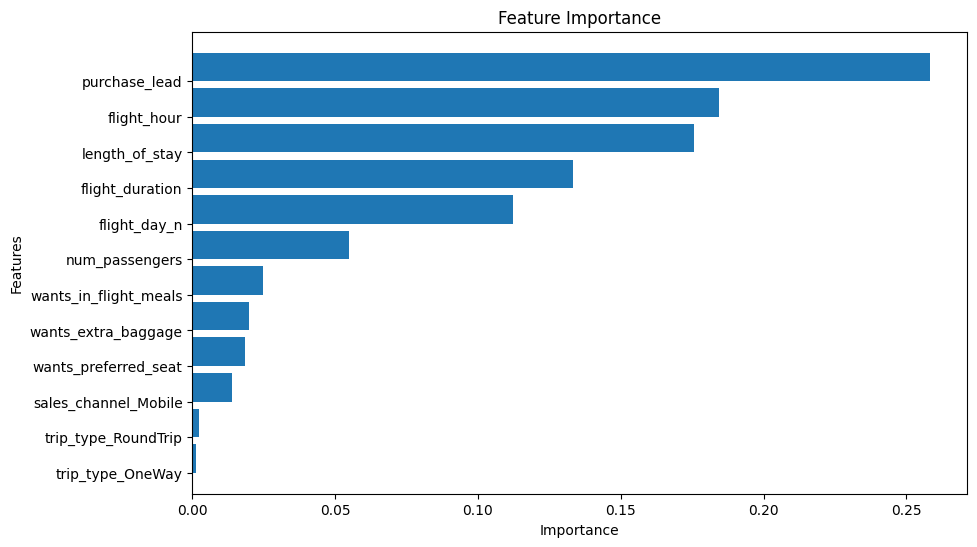

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['features'], feature_importance['importance'], align='edge')
plt.title('Feature Importance')
# plt.yticks(range(len(feature_importance)), feature_importance['features'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.savefig('feature_importance.png', transparent=True)
plt.show()